# IPEO Project: Hurricane Damage Detection with Deep Learning

# 1. Setup

### 1.1 Install dependencies

In [8]:
!pip install -U -q torch torchvision matplotlib tqdm gdown 

  You can safely remove it manually.


### 1.2 Check if GPU is available

In [9]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import WeightedRandomSampler, DataLoader
from collections import Counter

print(torch.cuda.is_available())

False


## 2. Data Loading

Data is already downloaded and stored in local IPEO folder

In [ ]:
!unzip ipeo_hurricane_damage.zip -d ipeo_hurricane_for_students # Use only one time to unzip data, I now have it downloaded locally and on the cluster

Archive:  ipeo_hurricane_damage.zip
   creating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/
   creating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/
   creating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/no_damage/
  inflating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/no_damage/-95.177399_30.033519000000002.jpeg  
  inflating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/no_damage/-95.66563000000001_29.835068.jpeg  
  inflating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/no_damage/-95.223651_30.02079.jpeg  
  inflating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/no_damage/-95.076075_30.030434999999997.jpeg  
  inflating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/no_damage/-95.2747_29.605709.jpeg  
  inflating: ipeo_hurricane_for_students/ipeo_hurricane_for_students/train/no_damage/-95.275817_29.608596000000002.jpeg  
  inflating: ipeo_hurr

### 2.1 Write a PyTorch Dataset class

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # somehow without this the data will not open
import glob


class Hurricane(Dataset):

    # mapping between folder names and indices
    LABEL_CLASSES = {
      'no_damage': 0,
      'damage': 1
    }


    def __init__(self, root_dir, transforms=None, split='train'):
        
        """
        root_dir: path to the extracted zip folder
        split: 'train', 'validation', or 'test'
        """

        self.transforms = transforms
        split_dir = os.path.join(root_dir, split)

        # prepare data
        self.data = []  # list of tuples of (image path, label class)

        for label_name, label_idx in self.LABEL_CLASSES.items():
            folder = os.path.join(split_dir, label_name)
            
            images = glob.glob(os.path.join(folder, "*.jpeg"))

            for img_path in images:
                self.data.append((img_path, label_idx))

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path)

        # apply transformation
        if self.transforms is not None:
            img = self.transforms(img)

        # return image and label
        return img, label


Look at a random sample to understand what the pictures look like.

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

dataset = Hurricane(
    root_dir="ipeo_hurricane_for_students", # Change this path if needed
    split="train",
    transforms=None
)

print(len(dataset))        # should be >0
print(dataset.data[:5])    # should show tuples (image_path, label)

@interact(idx=range(len(dataset)))
def plot_sample(idx=10000):
    img, label = dataset[idx]

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

19000
[('ipeo_hurricane_for_students/train/no_damage/-95.63417_29.854513.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.62729499999999_29.856902.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.17655400000001_30.036413.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.168351_29.43715.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.631024_29.857837.jpeg', 0)]


interactive(children=(Dropdown(description='idx', index=10000, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …

### 2.2 Define transforms

First, I calculate the mean and standard deviation of my test data to normalize the data

In [25]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import numpy as np

# Temporary transform to load images as tensors (no normalization!)
to_tensor = v2.ToTensor()

def compute_mean_std(dataset, batch_size=32):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    n_pixels = 0
    mean_sum = torch.zeros(3)
    std_sum = torch.zeros(3)

    for images, _ in loader: 
        imgs = images

        n_pixels += imgs.numel() / 3  # total per channel
        mean_sum += imgs.sum(dim=[0,2,3])
        std_sum += (imgs ** 2).sum(dim=[0,2,3])

    mean = mean_sum / n_pixels
    std = torch.sqrt(std_sum / n_pixels - mean**2)
    return mean, std


# Now I calculate the mean and std of the training dataset

train_dataset_noaug = Hurricane(
    root_dir="ipeo_hurricane_for_students",
    split="train",
    transforms=to_tensor     # only convert to tensor
)

mean, std = compute_mean_std(train_dataset_noaug)
print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.3518, 0.3832, 0.2849])
Std: tensor([0.1439, 0.1243, 0.1257])


I now implement transformations to the training data for data augmentation

In [ ]:



# mean and standard deviation of the dataset
mean= torch.tensor([0.3518, 0.3832, 0.2849])
std= torch.tensor([0.1439, 0.1243, 0.1257])

# Poisson Noise
class PoissonNoise(torch.nn.Module):
    def __init__(self, lam=30.0):
        """
        lam controls noise strength:
        larger = less noise, smaller = more noise
        """
        super().__init__()
        self.lam = lam

    def forward(self, x):
        # x is a tensor in [0, 1]
        # scale → sample → rescale
        noisy = torch.poisson(x * self.lam) / self.lam
        return torch.clamp(noisy, 0.0, 1.0)
    
# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = v2.Normalize(mean, std)

# I invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = v2.Normalize(-mean * std_inv, std_inv)

transforms_train = v2.Compose([
  v2.RandomResizedCrop((200, 200)),
  v2.RandomGrayscale(),
  v2.RandomHorizontalFlip(),
  v2.RandomVerticalFlip(),
  v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
  v2.RandomPosterize(bits=2),
  v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
  v2.Resize((224, 224)),
  v2.ToTensor(),
  PoissonNoise(lam=30.0), 
  normalize
])

# I do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = v2.Compose([
  v2.Resize((224, 224)),
  v2.ToTensor(),
  normalize
])

I now visualize the data transformation

[(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5)),
 (np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))]

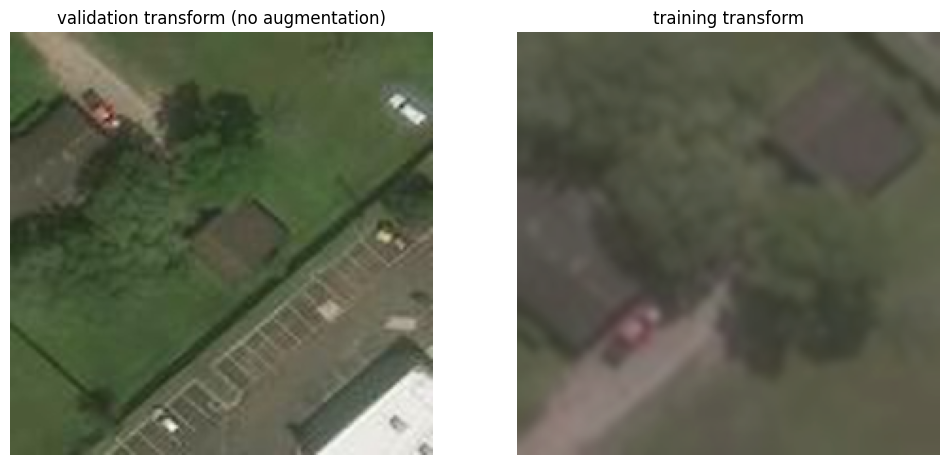

In [30]:
dataset_index = 500

img, label = dataset[dataset_index]

fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(unnormalize(transforms_val(img)).permute(1,2,0))
axs[0].set_title("validation transform (no augmentation)")

axs[1].imshow(unnormalize(transforms_train(img)).permute(1,2,0))
axs[1].set_title("training transform")
[ax.axis("off") for ax in axs] 

I now add the transform function to the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.401592e-07..0.9019612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.401592e-07..0.5725493].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450746..1.0000005].


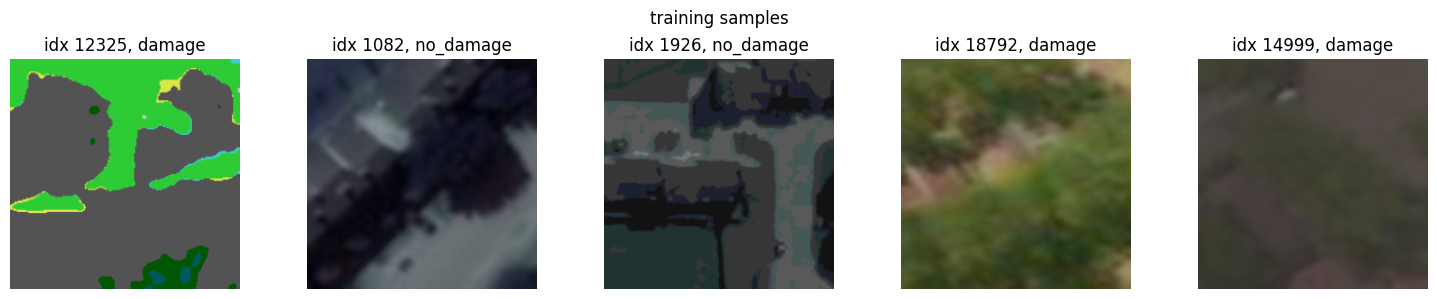

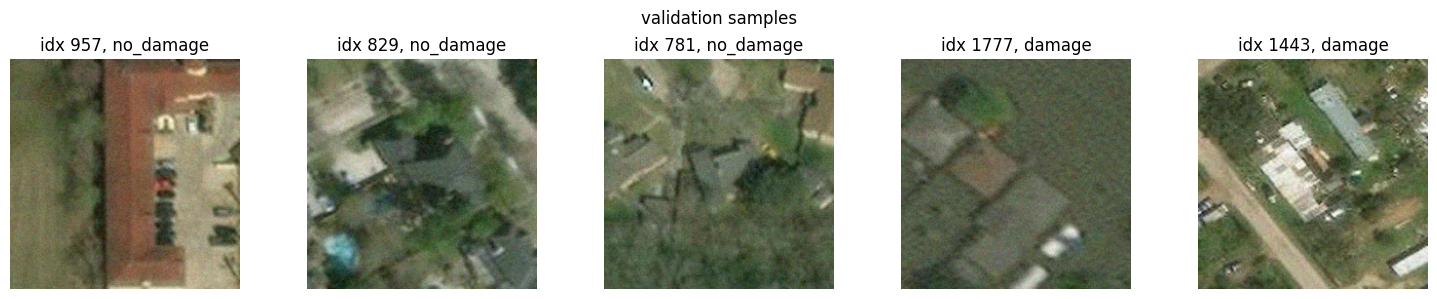

In [ ]:
train_dataset = Hurricane(root_dir="ipeo_hurricane_for_students",  split="train", transforms=transforms_train)
val_dataset = Hurricane(root_dir="ipeo_hurricane_for_students", split= 'validation', transforms=transforms_val)
test_dataset = Hurricane(root_dir="ipeo_hurricane_for_students", split= 'test', transforms=transforms_val)

# Visualization
fig, axs = plt.subplots(1,5, figsize=(5*3, 3))
for ax in axs:
    idx = np.random.randint(len(train_dataset)) # random sample
    image, label = train_dataset[idx]
    ax.imshow(unnormalize(image).permute(1,2,0))
    ax.set_title(f"idx {idx}, {list(Hurricane.LABEL_CLASSES.keys())[label]}")
    ax.axis("off")

fig.suptitle("training samples")
plt.tight_layout()

fig, axs = plt.subplots(1,5, figsize=(5*3, 3))
for ax in axs:
    idx = np.random.randint(len(val_dataset)) # random sample
    image, label = val_dataset[idx]
    ax.imshow(unnormalize(image).permute(1,2,0))
    ax.set_title(f"idx {idx}, {list(Hurricane.LABEL_CLASSES.keys())[label]}")
    ax.axis("off")

fig.suptitle("validation samples")
plt.tight_layout()

In [ ]:
### ----------DataLoader creation---------
### Compute class weights for balanced sampling
train_labels = [label for _, label in train_dataset.samples]

class_counts = torch.bincount(torch.tensor(train_labels))               # Count number of samples per class, here [1300, 6000]
class_weights = 1.0 / class_counts                                      # Inverse frequency, here [1/1300, 1/6000]
sample_weights = [class_weights[label] for label in train_labels]       # Assign weight to each sample based on its class

# Test if the weights are correct
# contribution totale par classe
total_weight_class0 = class_weights[0] * class_counts[0]
total_weight_class1 = class_weights[1] * class_counts[1]

total = total_weight_class0 + total_weight_class1

print("Sampling probabilities (true):")
print("damage (0)    →", (total_weight_class0 / total).item())
print("no_damage (1) →", (total_weight_class1 / total).item())

# The train batch are now sampled equally from all classes
# Each bach has the same number of samples from each class on average
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

### 4. Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)